# Imports necessary for fast.ai

In [1]:
from fastai import * 
from fastai.vision import *

# Pet classifier from Oxford-IIIT Pet dataset

We can use untar_data to get data from a URL and extract this file. Fast.ai has a S3 bucket for a few datasets which can be accessed using URLs.dataset_name.

With the PET dataset we have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation. 

<img src="https://www.robots.ox.ac.uk/~vgg/data/pets/breed_count.jpg" alt="Stats">

In [2]:
URLs.MNIST

'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png'

In [3]:
path = untar_data(URLs.PETS)
path

PosixPath('/home/sid/.fastai/data/oxford-iiit-pet')

In [4]:
path.ls()

[PosixPath('/home/sid/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/sid/.fastai/data/oxford-iiit-pet/images')]

In [5]:
path_anno = path/'annotations'
path_img = path/'images'

## Extract images alone from the folder
    * get_image_files will extract all the files which are images from their extensions.
    * ImageDataBunch has a set factory functions which helps retrieve a set of datasets.
    * Most datasets are obtained as DataBunch

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/sid/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_40.jpg'),
 PosixPath('/home/sid/.fastai/data/oxford-iiit-pet/images/British_Shorthair_58.jpg'),
 PosixPath('/home/sid/.fastai/data/oxford-iiit-pet/images/shiba_inu_147.jpg')]

In [7]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [8]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),size=224)
data.normalize(imagenet_stats) # Used to normalize all channels as some channels may be over r

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,British_Shorthair,shiba_inu,japanese_chin,american_bulldog
Path: /home/sid/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
japanese_chin,miniature_pinscher,pug,english_cocker_spaniel,newfoundland
Path: /home/sid/.fastai/data/oxford-iiit-pet/images;

Test: None

## Display contents in DataBunch

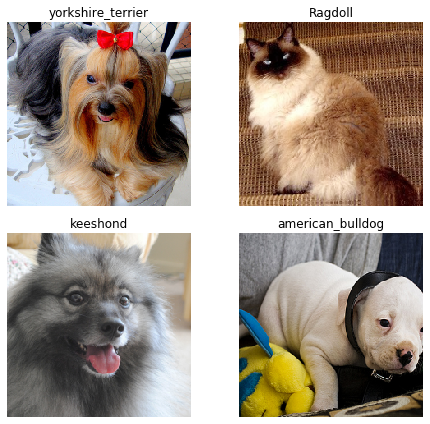

In [9]:
data.show_batch(rows=2,figsize=(7,6))

In [10]:
#The classes property takes the classes from a Data bunch in this case an ImageDataBunch
print(data.classes[:5],'\nLength',len(data.classes))

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair'] 
Length 37


## Training the model

The ConvLearner is used to download pre-trained weights of a specific model 

In [11]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

In [12]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.242889,0.325920,0.102165,00:55
1,0.554271,0.250602,0.081867,00:58
2,0.336497,0.221877,0.073072,01:02


In [13]:
learn.save('r34-v1')

## Trying out the algorithm - Results

In [14]:
pred = ClassificationInterpretation.from_learner(learn)

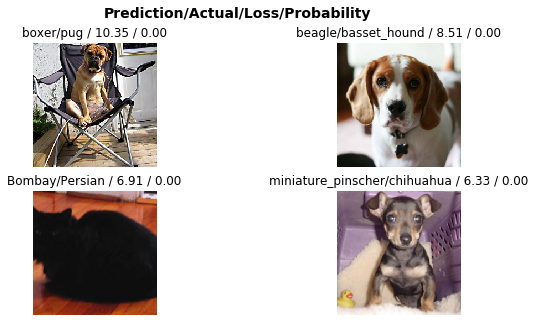

In [20]:
pred.plot_top_losses(4, figsize=(10,5))

In [22]:
doc(pred.plot_top_losses) #Opens up fastai doc for the fn

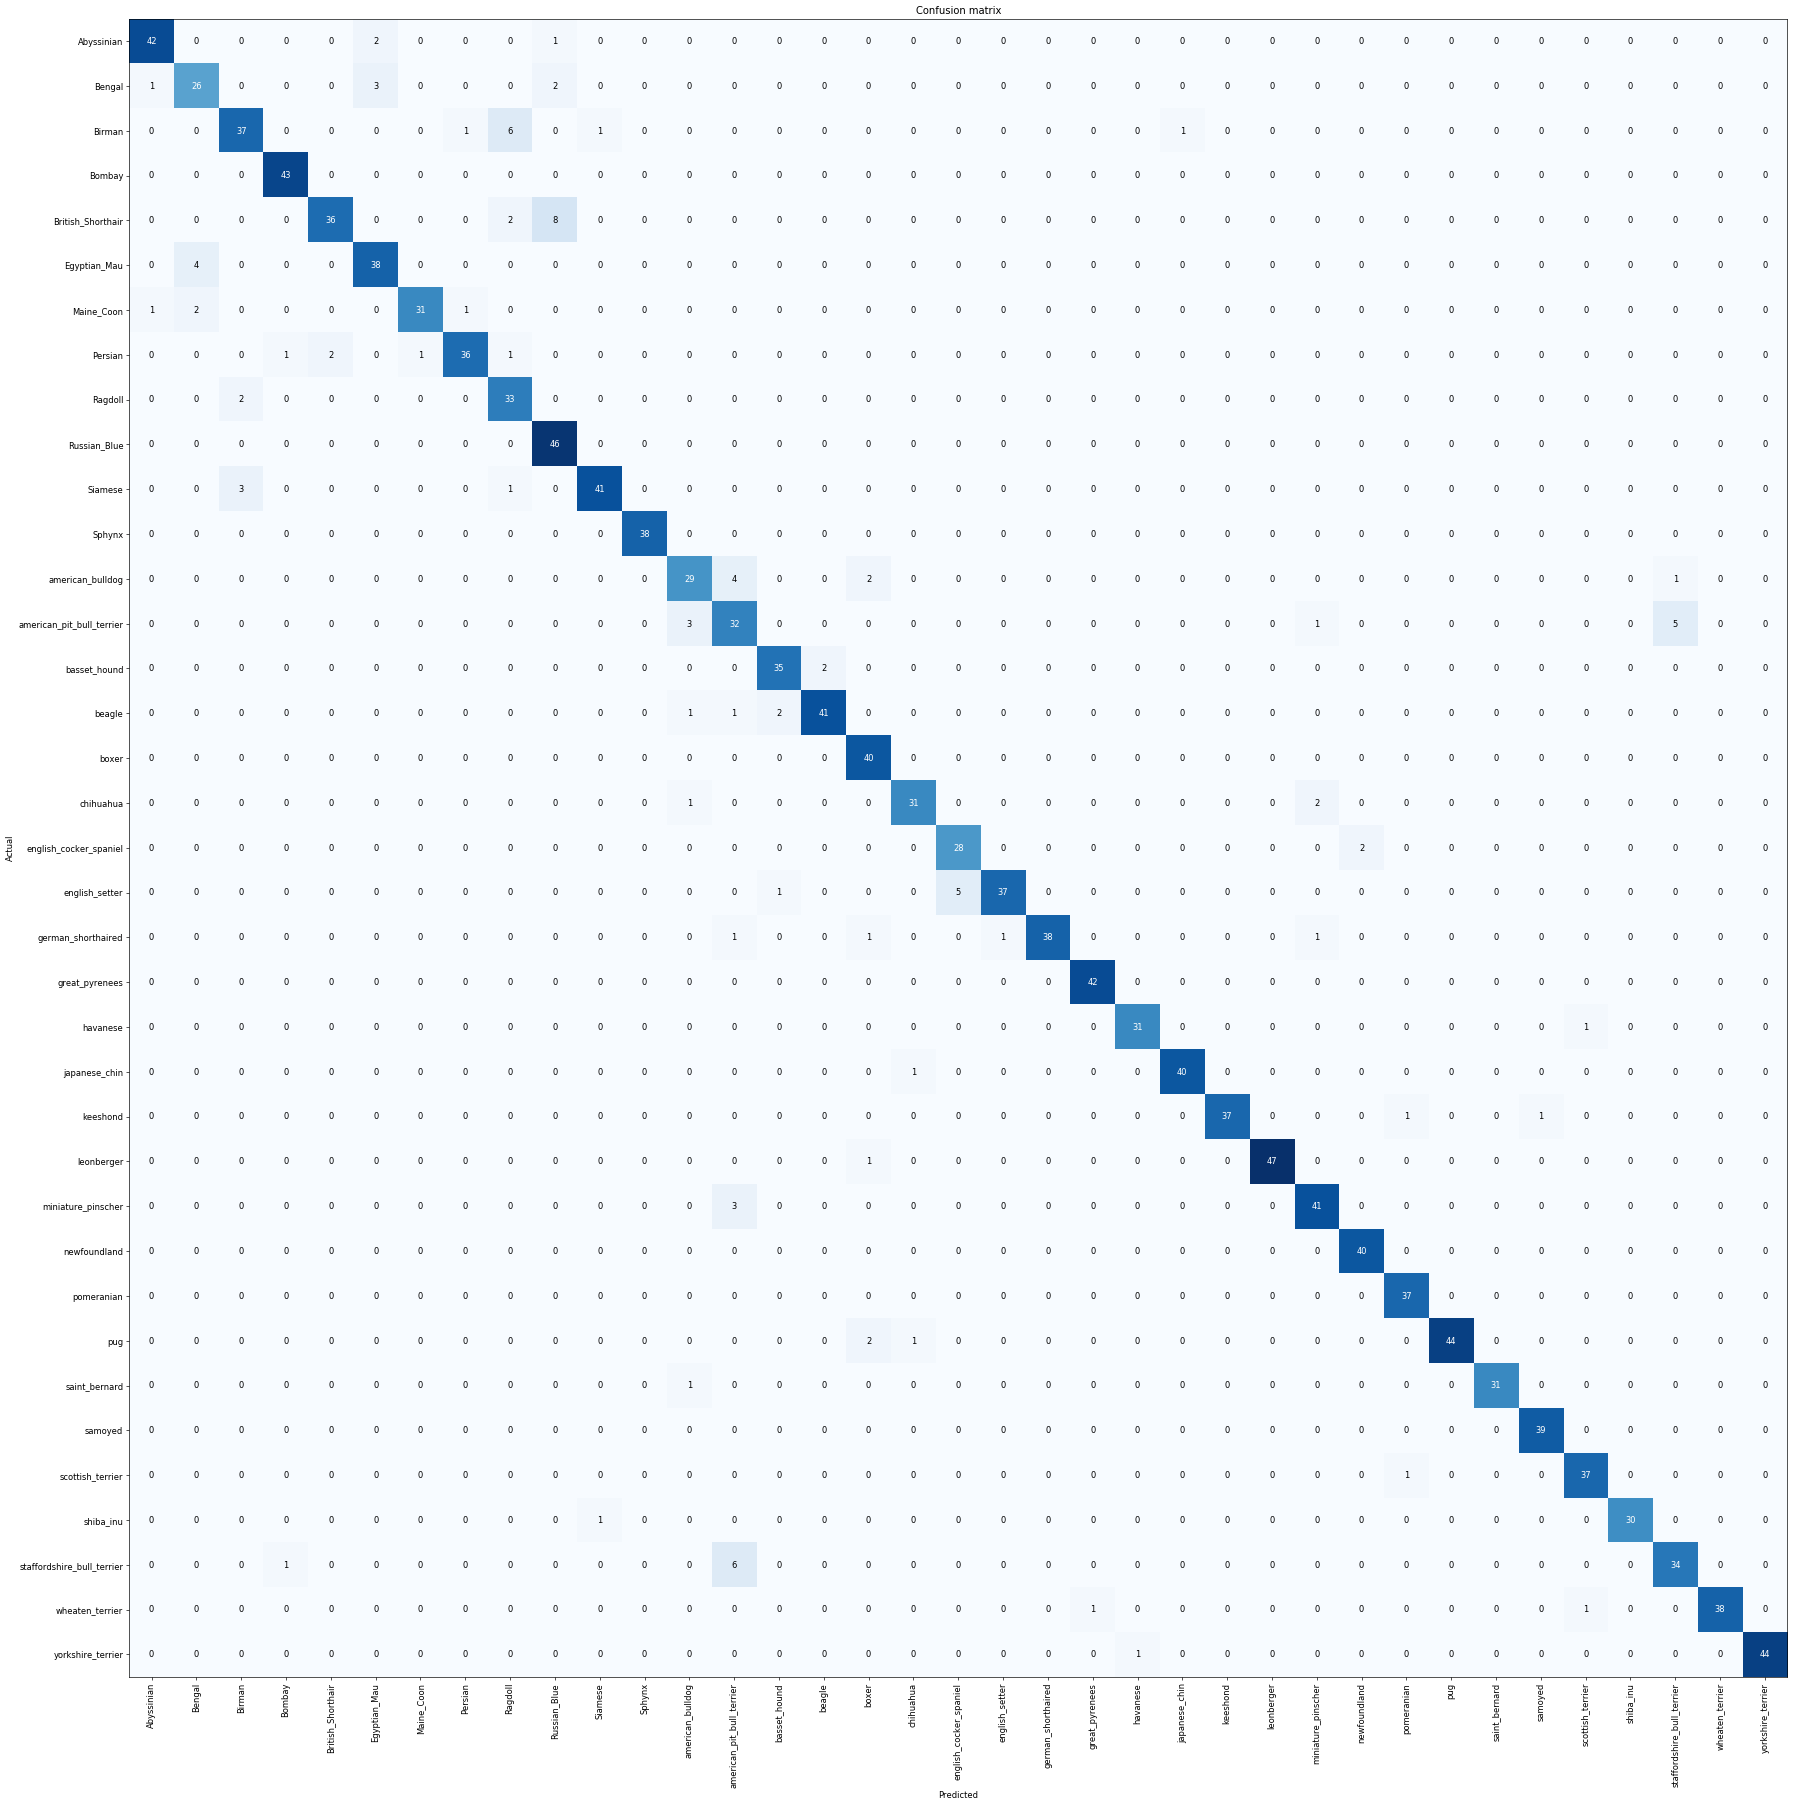

In [28]:
#Confusion matrix plot when <10 classes
pred.plot_confusion_matrix(dpi=60,figsize=(30,30))

In [31]:
#Helps get the class which was predicted badly more number of times
pred.most_confused(min_val=3)

[('British_Shorthair', 'Russian_Blue', 8),
 ('Birman', 'Ragdoll', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('english_setter', 'english_cocker_spaniel', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3)]

## Training a new model for learner

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.684827,0.384967,0.119080,01:17


In [34]:
learn.load('r34-v1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,British_Shorthair,shiba_inu,japanese_chin,american_bulldog
Path: /home/sid/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
japanese_chin,miniature_pinscher,pug,english_cocker_spaniel,newfoundland
Path: /home/sid/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
      

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


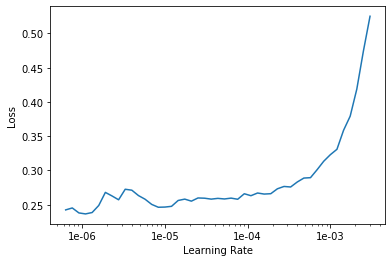

In [36]:
learn.recorder.plot()

In [38]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.288136,0.211511,0.069012,01:16
1,0.253985,0.213668,0.067659,01:26
